In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_unixtime
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, IndexToString
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from pyspark.sql.functions import col, sum as _sum, regexp_replace, length

In [4]:
# Start Spark session
spark = SparkSession.builder \
    .appName("SteamReviewsHDFS") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "100")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()  

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/05 19:03:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.csv("hdfs:///user/vineeth/project/data/raw/steam_reviews.csv", header=True, inferSchema=True)

# Preview
df.show(5)

+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|_c0|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author.steamid|author.num_games_owned|author.num_reviews|author.playtime_forever|author.playtime_last_two_weeks|author.playtime_at_review|author.last_played|
+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-----

25/05/05 19:04:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, review, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, review, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/vineeth/project/data/raw/steam_reviews.csv


In [6]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- recommended: string (nullable = true)
 |-- votes_helpful: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: string (nullable = true)
 |-- author.steamid: string (nullable = true)
 |-- author.num_games_owned: string (nullable = true)
 |-- author.num_reviews: string (nullable = true)
 |-- author.playtime_forever: string (nullable = true)
 |-- author.playtime_last_two_weeks: string (nullable = true)
 |-- author.playt

In [7]:
df.count()

40848659

#### Data Cleaning and Pre-Processing

In [8]:
data_csv = df.withColumnRenamed("author.steamid","author_steamid"). \
withColumnRenamed("author.num_games_owned","author_num_games_owned").\
withColumnRenamed("author.num_reviews", "author_num_reviews").\
withColumnRenamed("author.playtime_forever","author_playtime_forever").\
withColumnRenamed("author.playtime_at_review","author_playtime_at_review").\
withColumnRenamed("author.last_played","author_last_played").\
withColumnRenamed("author.playtime_last_two_weeks", "author_playtime_last_two_weeks")


#### Converted the column names into valid names - removed the dots and replace them with underscore.

In [9]:
data_csv.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- recommended: string (nullable = true)
 |-- votes_helpful: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playt

In [10]:

columns_to_check = [c for c in data_csv.columns if c != '_c0']

null_counts = data_csv.select([
    _sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_check
])


In [11]:
null_counts_pd = null_counts.toPandas()
print(null_counts_pd.T)  # T = transpose

/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
[Stage 6:======================================================>  (58 + 3) / 61]

                                       0
app_id                          11335874
app_name                        13077913
review_id                       13975798
language                        14498420
review                          14860610
timestamp_created               19928219
timestamp_updated               20104213
recommended                     20217490
votes_helpful                   20296075
votes_funny                     20350386
weighted_vote_score             20389679
comment_count                   20417234
steam_purchase                  20437907
received_for_free               20452713
written_during_early_access     20464051
author_steamid                  20476095
author_num_games_owned          20480003
author_num_reviews              22945129
author_playtime_forever         23511575
author_playtime_last_two_weeks  23759374
author_playtime_at_review       23902511
author_last_played              23951902


#### Drop rows missing app_id, review_id, review, recommended (core fields) ➡ Fill numeric columns like votes_helpful, votes_funny with 0 ➡ Ignore user info if missing (optional for dashboard)

In [12]:
important_cols = ["app_id","app_name", "review_id", "review", "recommended","author_steamid"]
numeric_fill_cols = ["votes_helpful", "votes_funny", "comment_count", "weighted_vote_score"]

In [13]:
df_clean = data_csv.dropna(subset=important_cols)

#Fill numeric columns (votes helpful, funny, comment_count) with 0 where NULL
for col_name in numeric_fill_cols:
    df_clean = df_clean.withColumn(col_name, coalesce(col_name, lit(0)))

#fill steam_purchase, received_for_free to 'Unknown'
df_clean = df_clean.fillna({
    "steam_purchase": "unknown",
    "received_for_free": "unknown"
})

### Normalise text

In [14]:
df_clean = df_clean.withColumn(
    "cleaned_review",
    regexp_replace(
        lower(col("review")),
        "<[^>]*>",  # Remove HTML
        ""
    )
)
df_clean = df_clean.withColumn(
    "cleaned_review",
    regexp_replace(
        col("cleaned_review"),
        "[^\\p{L}\\s]",  # Keep Unicode letters and whitespace only
        ""
    )
)
df_clean = df_clean.withColumn("cleaned_review", trim(col("cleaned_review")))


In [15]:
df_sample = df_clean.limit(10).toPandas()
print(df_sample)

/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
25/05/05 19:16:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, review, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, review, timestamp

  _c0  app_id                  app_name review_id  language  \
0   0  292030  The Witcher 3: Wild Hunt  85185598  schinese   
1   1  292030  The Witcher 3: Wild Hunt  85185250  schinese   
2   2  292030  The Witcher 3: Wild Hunt  85185111  schinese   
3   3  292030  The Witcher 3: Wild Hunt  85184605   english   
4   4  292030  The Witcher 3: Wild Hunt  85184287  schinese   
5   5  292030  The Witcher 3: Wild Hunt  85184171   english   
6   6  292030  The Witcher 3: Wild Hunt  85184064   english   
7   8  292030  The Witcher 3: Wild Hunt  85183227  schinese   
8   9  292030  The Witcher 3: Wild Hunt  85182785   spanish   
9  10  292030  The Witcher 3: Wild Hunt  85182697  schinese   

                                              review timestamp_created  \
0                            不玩此生遗憾，RPG游戏里的天花板，太吸引人了        1611381629   
1                                 拔DIAO无情打桩机--杰洛特!!!        1611381030   
2                                              巫师3NB        1611380800   
3  One of 

In [16]:
df_clean.count()

20337579

In [17]:
df_clean.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- recommended: string (nullable = true)
 |-- votes_helpful: string (nullable = false)
 |-- votes_funny: string (nullable = false)
 |-- weighted_vote_score: string (nullable = false)
 |-- comment_count: string (nullable = false)
 |-- steam_purchase: string (nullable = false)
 |-- received_for_free: string (nullable = false)
 |-- written_during_early_access: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author

### Changing the data type of each columns into appropriate types

In [18]:
df_clean = df_clean.withColumn("app_id",df_clean["app_id"].cast(IntegerType())).\
            withColumn("review_id", df_clean["review_id"].cast(LongType())).\
            withColumn("author_steamid", df_clean["author_steamid"].cast(LongType())).\
            withColumn("recommended", df_clean["recommended"].cast(BooleanType())).\
            withColumn("steam_purchase", df_clean["steam_purchase"].cast(BooleanType())).\
            withColumn("author_num_games_owned", df_clean["author_num_games_owned"].cast(IntegerType())).\
            withColumn("author_num_reviews", df_clean["author_num_reviews"].cast(IntegerType())).\
            withColumn("author_playtime_forever", df_clean["author_playtime_forever"].cast(FloatType())).\
            withColumn("author_playtime_at_review", df_clean["author_playtime_at_review"].cast(FloatType()))

In [19]:
df_clean = df_clean.withColumn("timestamp_created", from_unixtime("timestamp_created").cast("timestamp")).\
            withColumn("author_last_played", from_unixtime(df_clean["author_last_played"]).cast(TimestampType())).\
            withColumn("timestamp_updated", from_unixtime(df_clean["timestamp_updated"]).cast(TimestampType()))

In [20]:
df_clean.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: long (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: timestamp (nullable = true)
 |-- timestamp_updated: timestamp (nullable = true)
 |-- recommended: boolean (nullable = true)
 |-- votes_helpful: string (nullable = false)
 |-- votes_funny: string (nullable = false)
 |-- weighted_vote_score: string (nullable = false)
 |-- comment_count: string (nullable = false)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: string (nullable = false)
 |-- written_during_early_access: string (nullable = true)
 |-- author_steamid: long (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: float (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- a

In [21]:
df_clean = df_clean.filter(
    (~col("app_name").rlike("^[0-9]+$")) &    # app_name is NOT all numbers
    (~col("review").rlike("^[0-9]+$")) &    # app_name is NOT all numbers
    (~col("cleaned_review").rlike("^[0-9]+$"))            # review is NOT all numbers
)

# Optional: Check the result
df_clean.select("app_name", "review","cleaned_review").show(10, truncate=False)

+------------------------+-----------------------------------------------------------+---------------------------------------------------------+
|app_name                |review                                                     |cleaned_review                                           |
+------------------------+-----------------------------------------------------------+---------------------------------------------------------+
|The Witcher 3: Wild Hunt|不玩此生遗憾，RPG游戏里的天花板，太吸引人了                |不玩此生遗憾rpg游戏里的天花板太吸引人了                  |
|The Witcher 3: Wild Hunt|拔DIAO无情打桩机--杰洛特!!!                                |拔diao无情打桩机杰洛特                                   |
|The Witcher 3: Wild Hunt|巫师3NB                                                    |巫师nb                                                   |
|The Witcher 3: Wild Hunt|One of the best RPG's of all time, worthy of any collection|one of the best rpgs of all time worthy of any collection|
|The Witcher 3: Wild Hunt|大作                 

In [22]:
df_clean.count()

17026220

df_sample2 = df_clean.limit(10).toPandas()
print(df_sample2)

#### Save the cleaned data to HDFS in Parquet format

In [24]:
df_clean.write.mode("overwrite").parquet("/user/vineeth/project/data/processed/cleaned_steam_reviews.parquet")

25/05/05 19:21:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, review, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, review, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user/vineeth/project/data/raw/steam_reviews.csv
       

In [25]:
try:
    test_df = spark.read.parquet("/user/vineeth/project/data/processed/cleaned_steam_reviews.parquet")
    print("Parquet read successful. Number of rows:", test_df.count())
except Exception as e:
    print("Error reading parquet:", str(e))

Parquet read successful. Number of rows: 17026220


In [26]:
df_cleaned_parquet = spark.read.parquet("/user/vineeth/project/data/processed/cleaned_steam_reviews.parquet")

In [27]:
english_df = df_cleaned_parquet.filter(df_cleaned_parquet.language == "english")

In [28]:
english_df.write.mode("overwrite").parquet("/user/vineeth/project/data/processed/steam_review_english.parquet")

In [29]:

try:
    test_df = spark.read.parquet("/user/vineeth/project/data/processed/steam_review_english.parquet")
    print("Parquet read successful. Number of rows:", test_df.count())
except Exception as e:
    print("Error reading parquet:", str(e))

Parquet read successful. Number of rows: 7303168


### EDA

In [30]:
english_df = spark.read.parquet("/user/vineeth/project/data/processed/steam_review_english.parquet")

In [31]:
col_demo = ["app_id", "app_name", "review_id", "language", "author_steamid",
            "timestamp_created", "author_playtime_forever"]

col_author = ["steam_purchase", "author_steamid", "author_num_games_owned",
              "author_num_reviews", "author_playtime_forever"]

col_time = ["app_id", "app_name", "timestamp_created", "timestamp_updated",
            "author_playtime_at_review", "recommended"]

col_rev = ["app_id", "app_name", "language", "recommended"]

col_rec = ["app_id", "app_name", "recommended"]


#### Most Popular Games

In [32]:
app_names = english_df.groupBy("app_name").count()
app_names_count = app_names.orderBy(col("count").desc()).limit(20)

# Convert to Pandas for plotting
app_counts = app_names_count.toPandas()

/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

In [33]:
app_counts

,app_name,count
0,Terraria,306039
1,Tom Clancy's Rainbow Six Siege,299294
2,Garry's Mod,269046
3,Grand Theft Auto V,247979
4,Among Us,243806
5,PLAYERUNKNOWN'S BATTLEGROUNDS,243207
6,Rust,225434
7,Rocket League,200593
8,Stardew Valley,140207
9,PAYDAY 2,139557


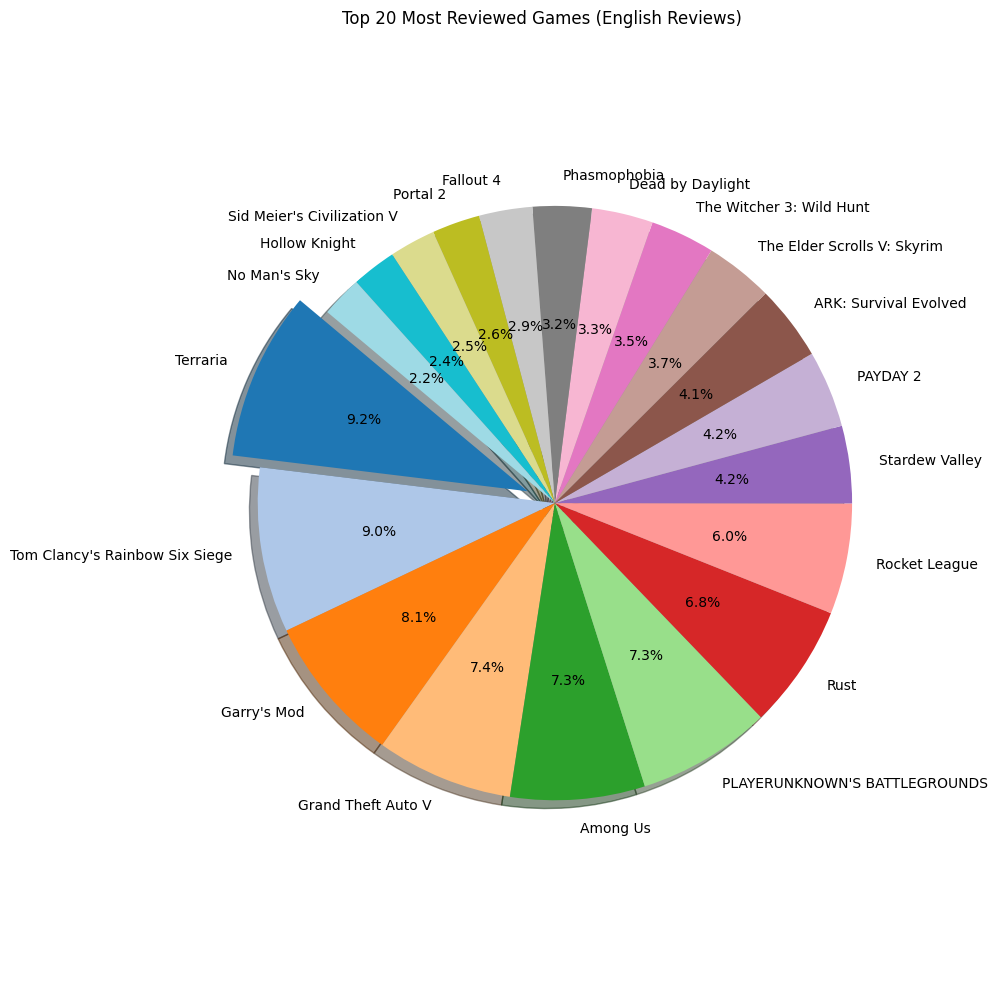

In [34]:
import matplotlib.pyplot as plt

# Prepare explode and colors
explode = [0.1] + [0] * 19
colors = plt.cm.tab20.colors

# Plot pie chart
plt.figure(figsize=(10, 10))
plt.pie(app_counts["count"],
        labels=app_counts["app_name"],
        colors=colors,
        explode=explode,
        shadow=True,
        startangle=140,
        autopct='%1.1f%%')

plt.title("Top 20 Most Reviewed Games (English Reviews)")
plt.axis('equal')
plt.tight_layout()
plt.show()


### Percentage of recommended = True by Game (Top 20)

In [35]:
# Total reviews per game
total_counts = english_df.groupBy("app_name").count()

# Only recommended reviews
true_counts = english_df.filter(english_df["recommended"] == True).groupBy("app_name").count()

# Join and calculate recommendation %
recommendation_stats = true_counts.alias("true").join(
    total_counts.alias("total"),
    on="app_name"
).select(
    col("app_name"),
    (col("true.count") / col("total.count") * 100).alias("recommendation_percent")
).orderBy(col("recommendation_percent").desc()).limit(20)

recommendation_stats_pd = recommendation_stats.toPandas()


/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


/var/folders/tr/db4czd8s5p72t4kg1tb2b47c0000gn/T/ipykernel_57006/2297421686.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recommendation_stats_pd, x="recommendation_percent", y="app_name", palette="viridis")


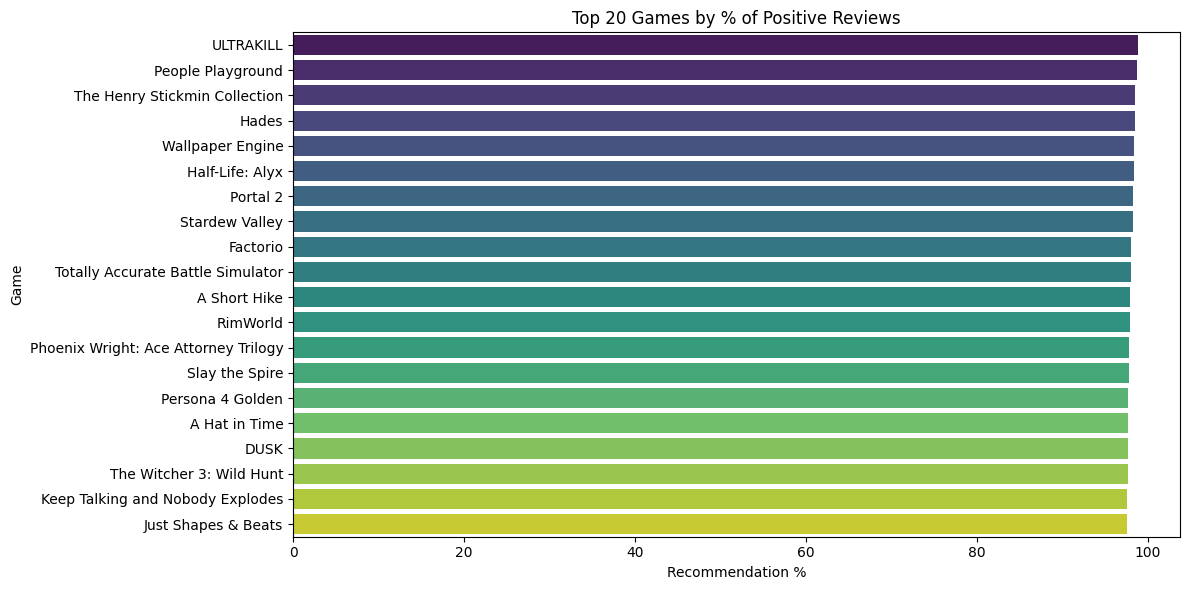

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(data=recommendation_stats_pd, x="recommendation_percent", y="app_name", palette="viridis")
plt.xlabel("Recommendation %")
plt.ylabel("Game")
plt.title("Top 20 Games by % of Positive Reviews")
plt.tight_layout()
plt.show()


In [37]:
from pyspark.sql.functions import count, when

# Filter PUBG
pubg_stats = english_df.filter(col("app_name").like("%BATTLEGROUNDS%")) \
    .agg(
        count("*").alias("total_reviews"),
        count(when(col("recommended") == True, True)).alias("recommended_reviews")
    )

pubg_stats.show()

# Calculate percent manually


+-------------+-------------------+
|total_reviews|recommended_reviews|
+-------------+-------------------+
|       243207|             155949|
+-------------+-------------------+



Games like ULTRAKILL, People Playground, and Hades top the chart.

#### Why pubg is missing in recommendation even after being higlhy reviewed?

PUBG has High raw review count (like in earlier pie chart), But relatively low % of “recommended = true”

### Recommendation Percentage vs. Review Count by Game

/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

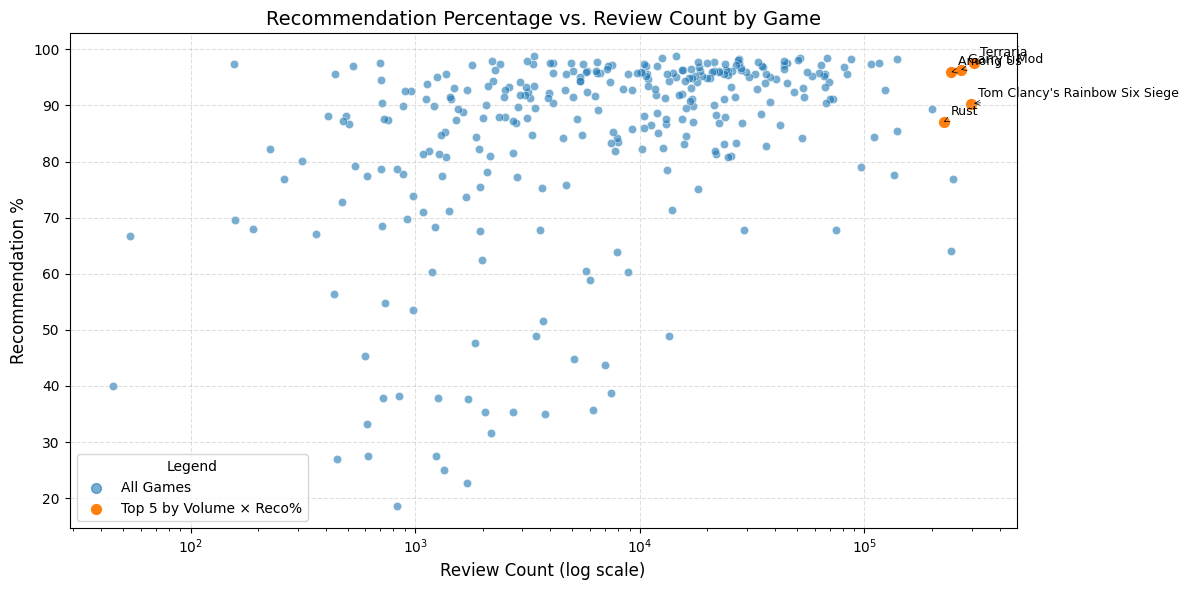

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# 1. Compute total reviews and recommendation % per game
total_counts = english_df.groupBy("app_name") \
    .count().withColumnRenamed("count", "review_count")

true_counts = english_df.filter(col("recommended") == True) \
    .groupBy("app_name") \
    .count().withColumnRenamed("count", "true_count")

rec_rate_df = true_counts.join(total_counts, "app_name") \
    .withColumn("recommendation_percent", (col("true_count") / col("review_count")) * 100)

# 2. Convert to Pandas and sort by review_count × recommendation_percent
rec_pd = rec_rate_df.select("app_name", "review_count", "recommendation_percent") \
    .orderBy(col("review_count").desc()) \
    .toPandas()

# 3. Identify top-5 “high-volume + high-reco” games
#    We pick the top 5 by (review_count * recommendation_percent) as a simple composite score
rec_pd["score"] = rec_pd["review_count"] * rec_pd["recommendation_percent"]
top5 = rec_pd.nlargest(5, "score")

# 4. Plot
plt.figure(figsize=(12,6))
sns.scatterplot(data=rec_pd, x="review_count", y="recommendation_percent", alpha=0.6)

# Annotate top-5
for _, row in top5.iterrows():
    plt.annotate(
        row["app_name"], 
        (row["review_count"], row["recommendation_percent"]),
        textcoords="offset points",
        xytext=(5,5),
        fontsize=9,
        arrowprops=dict(arrowstyle="->", lw=0.5)
    )

# Styling
plt.xscale('log')
plt.xlabel("Review Count (log scale)", fontsize=12)
plt.ylabel("Recommendation %", fontsize=12)
plt.title("Recommendation Percentage vs. Review Count by Game", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)

# Create a legend entry for the highlighted dots
plt.scatter([], [], s=50, c="C0", alpha=0.6, label="All Games")
plt.scatter(top5["review_count"], top5["recommendation_percent"], 
            s=50, c="C1", label="Top 5 by Volume × Reco%")
plt.legend(frameon=True, title="Legend")

plt.tight_layout()
plt.show()


1. **Popular & Loved** (Upper‐Right)
High review counts (often > 10 000) and ≥ 90% recommendation.

These are the genre‐defining blockbuster hits—millions of players loved them (e.g. Terraria, Garry’s Mod).

2. **Hidden Gems**  (Upper‐Left)
Low review counts (often < 1 000) but very high recommendation (> 90–95%).

Smaller titles with passionate fanbases. These are prime candidates to showcase in a “you might also enjoy” widget.

3. **Controversial Hits**  (Lower‐Right)
Very high review counts but moderate recommendation rates (60–80%).

Big-name games that sparked mixed opinions—great for deep‐dive write-ups on what divided players.

### Hidden Gems: ≥95% Recommended & <10 000 Reviews

/var/folders/tr/db4czd8s5p72t4kg1tb2b47c0000gn/T/ipykernel_57006/2140147116.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave space for the colorbar
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


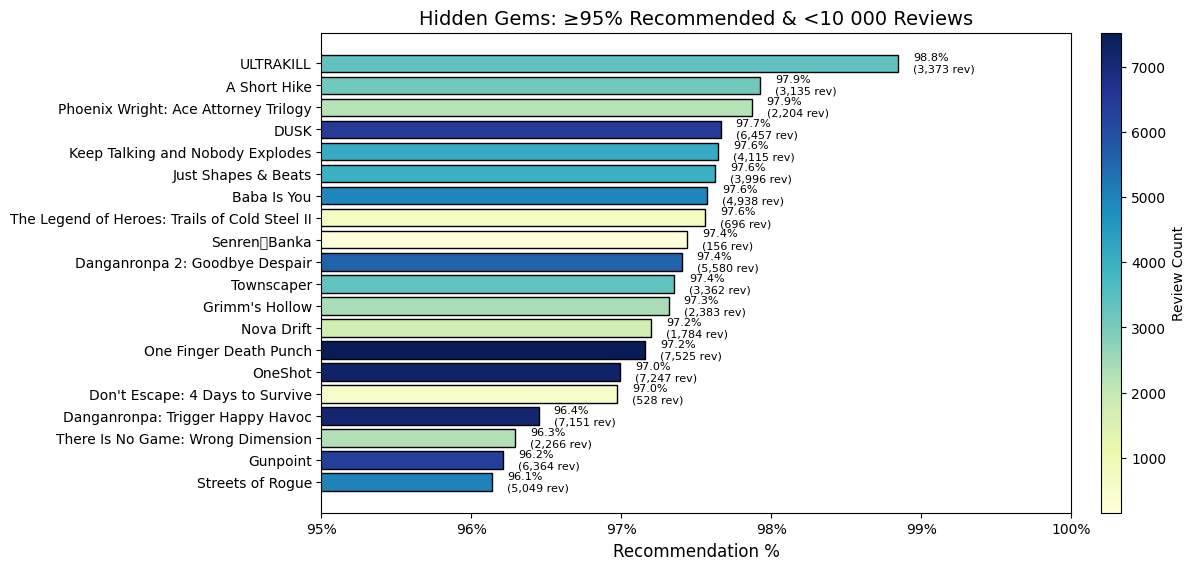

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# (re-use your gems_pd from before)

# Create figure with two axes: one for bars, one for the colorbar
fig = plt.figure(figsize=(10, 6))
# main plotting area
ax = fig.add_axes([0.10, 0.10, 0.75, 0.80])   # [left, bottom, width, height]
# colorbar area
cax = fig.add_axes([0.88, 0.10, 0.02, 0.80])

# Normalize review_count → 95–(max) range
norm = plt.Normalize(gems_pd.review_count.min(), gems_pd.review_count.max())
colors = plt.cm.YlGnBu(norm(gems_pd.review_count))

# Draw horizontal bars
bars = ax.barh(
    y=gems_pd["app_name"],
    width=gems_pd["recommendation_percent"],
    color=colors,
    edgecolor="k"
)

# Annotate each bar
for bar, pct, cnt in zip(bars, gems_pd.recommendation_percent, gems_pd.review_count):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        x + 0.1, y,
        f"{pct:.1f}%\n({cnt:,} rev)",
        va="center", ha="left", fontsize=8
    )

# Invert Y so highest % sits at the top
ax.invert_yaxis()
ax.set_xlim(95, 100)
ax.set_xticks(np.arange(95, 101))
ax.set_xticklabels([f"{i}%" for i in range(95, 101)])
ax.set_xlabel("Recommendation %", fontsize=12)
ax.set_title("Hidden Gems: ≥95% Recommended & <10 000 Reviews", fontsize=14)

# Draw the colorbar into our cax
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cax, label="Review Count")

plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave space for the colorbar
plt.show()


**ULTRAKILL** sits at the very top—98.8% recommended but only ~3,400 reviews.

- A “long tail” of smaller indies follows: A Short Hike, Phoenix Wright: Ace Attorney Trilogy, DUSK, etc., all with spectacular praise but between a few hundred and a few thousand reviewers.

### Steam Review Volume Over Time (English)

/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

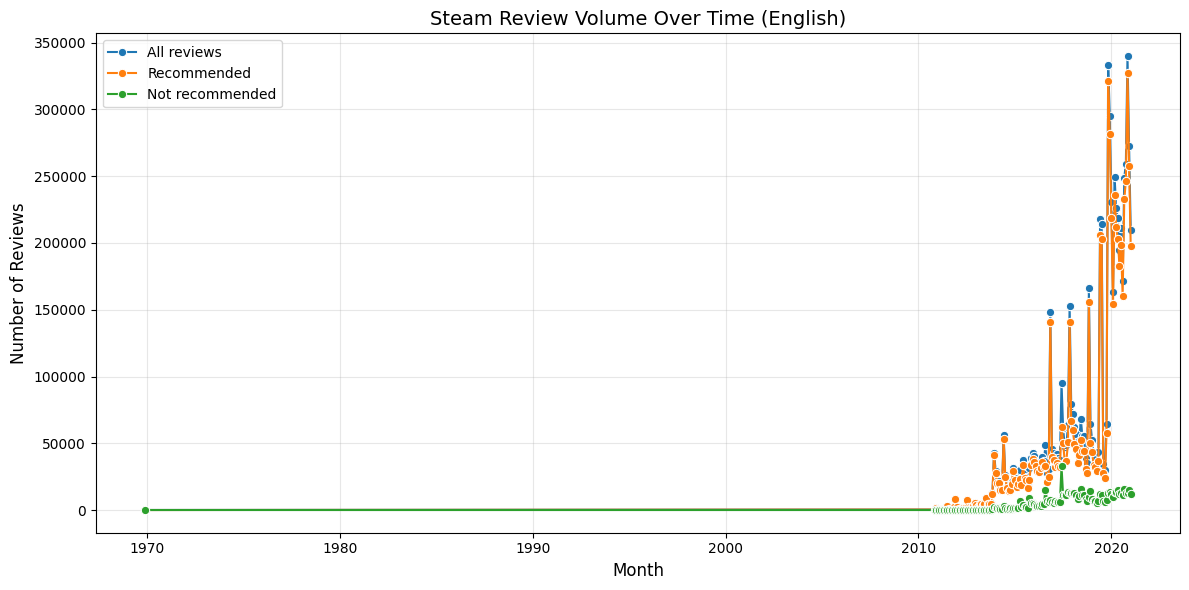

In [47]:
# 1a) Bucket into month periods
df_time = (
    english_df
    .withColumn("month", date_trunc("month", col("timestamp_created")))
    .groupBy("month")
    .agg(
        count("*").alias("total_reviews"),
        count(when(col("recommended")==True, True)).alias("positive_reviews"),
        count(when(col("recommended")==False, True)).alias("negative_reviews")
    )
    .orderBy("month")
)

# 1b) Pull into Pandas
time_pd = df_time.toPandas()
time_pd["month"] = pd.to_datetime(time_pd["month"])

# 1c) Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_pd, x="month", y="total_reviews", label="All reviews", marker="o")
sns.lineplot(data=time_pd, x="month", y="positive_reviews", label="Recommended", marker="o")
sns.lineplot(data=time_pd, x="month", y="negative_reviews", label="Not recommended", marker="o")

plt.title("Steam Review Volume Over Time (English)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.legend(title="")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Most Common Meaningful Words by Sentiment

/var/folders/tr/db4czd8s5p72t4kg1tb2b47c0000gn/T/ipykernel_57006/2989539612.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/tr/db4czd8s5p72t4kg1tb2b47c0000gn/T/ipykernel_57006/2989539612.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


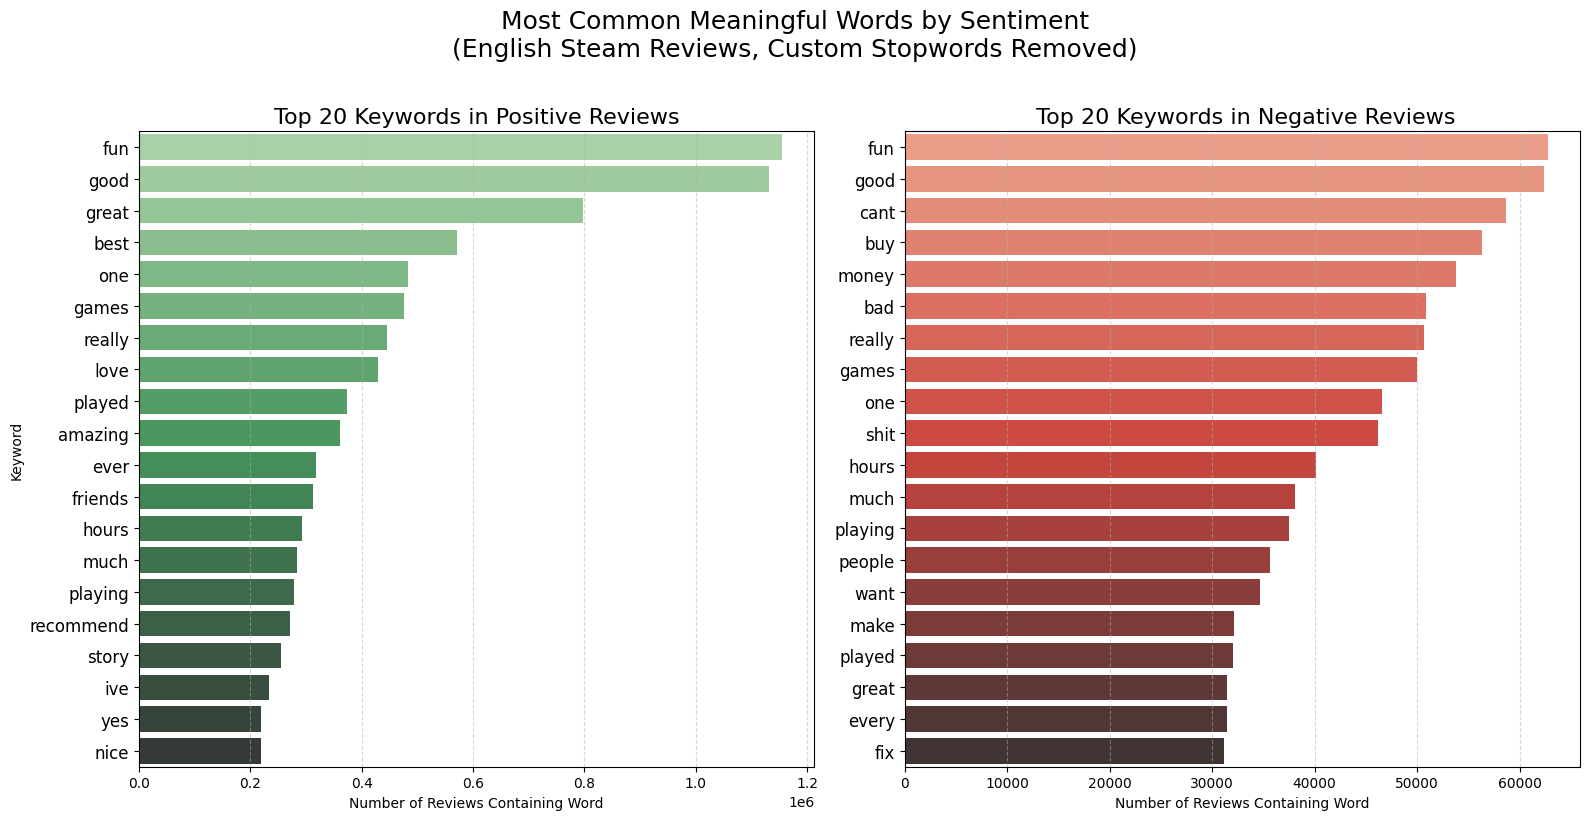

In [60]:
# 1) Imports
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# 2) Define your extra stop-words
extra_stops = ["game","play","like","get","even","time","dont","still",
               "bug","crash","lag","refund","error","disconnect","freeze"]

# 3) Tokenize the cleaned_review column
tokenizer = Tokenizer(inputCol="cleaned_review", outputCol="tokens_raw")
tokens_df = tokenizer.transform(english_df)

# 4) Trim out super-short tokens (≤2 chars)
tokens_df = tokens_df.withColumn(
    "tokens_trimmed",
    F.expr("filter(tokens_raw, x -> length(x) > 2)")
)

# 5) Remove stop-words (Spark’s default + your extras)
remover = StopWordsRemover(
    inputCol="tokens_trimmed",
    outputCol="tokens_clean"
)
# get default list and extend:
custom_list = StopWordsRemover.loadDefaultStopWords("english") + extra_stops
remover.setStopWords(custom_list)
tokens_df = remover.transform(tokens_df)

# 6) Explode each cleaned token into its own row, keep the `recommended` flag
exploded = tokens_df.select(
    "recommended",
    F.explode("tokens_clean").alias("word")
)

# 7) Count top 20 Positive
pos_counts_pd = (
    exploded
      .filter(F.col("recommended") == True)
      .groupBy("word")
      .count()
      .orderBy(F.col("count").desc())
      .limit(20)
      .toPandas()
)

# 8) Count top 20 Negative
neg_counts_pd = (
    exploded
      .filter(F.col("recommended") == False)
      .groupBy("word")
      .count()
      .orderBy(F.col("count").desc())
      .limit(20)
      .toPandas()
)

# 9) Plot side-by-side
plt.figure(figsize=(16,8))
ax_pos = plt.subplot(1,2,1)
sns.barplot(
    data=pos_counts_pd,
    x="count", y="word",
    palette="Greens_d",
    ax=ax_pos
)
ax_pos.set_title("Top 20 Keywords in Positive Reviews", fontsize=16)
ax_pos.set_xlabel("Number of Reviews Containing Word")
ax_pos.set_ylabel("Keyword")            # <-- full y-axis labels on LEFT panel

ax_neg = plt.subplot(1,2,2)
sns.barplot(
    data=neg_counts_pd,
    x="count", y="word",
    palette="Reds_d",
    ax=ax_neg
)
ax_neg.set_title(" Top 20 Keywords in Negative Reviews", fontsize=16)
ax_neg.set_xlabel("Number of Reviews Containing Word")
ax_neg.set_ylabel("")                  # <-- intentionally blank, but shows ticklabels

# Make sure the y-tick labels show on both panels
for ax in (ax_pos, ax_neg):
    ax.tick_params(axis="y", labelsize=12)
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)

plt.suptitle(
    "Most Common Meaningful Words by Sentiment\n"
    "(English Steam Reviews, Custom Stopwords Removed)",
    fontsize=18, y=1.02
)
plt.tight_layout()
plt.show()


Even after stripping out your “obvious” stop-words and app terms, we still see words like fun, good or great in the “negative” list. why?

We defined “negative” reviews as simply those with **recommended == False**. But in every review—even the ones tagged as “not recommended”, people still use lots of the same common words (“fun,” “good,” “great”) when explaining why they’re disappointed. 

#### For example: “It was fun, but way too buggy.”

#### “The graphics are great, but the story makes no sense.”

In other words, those words are still among the most frequent tokens in the negative subset, even though the overall sentiment is a “thumbs-down.”

### Monthly Review Trends for Top 10 Steam Games

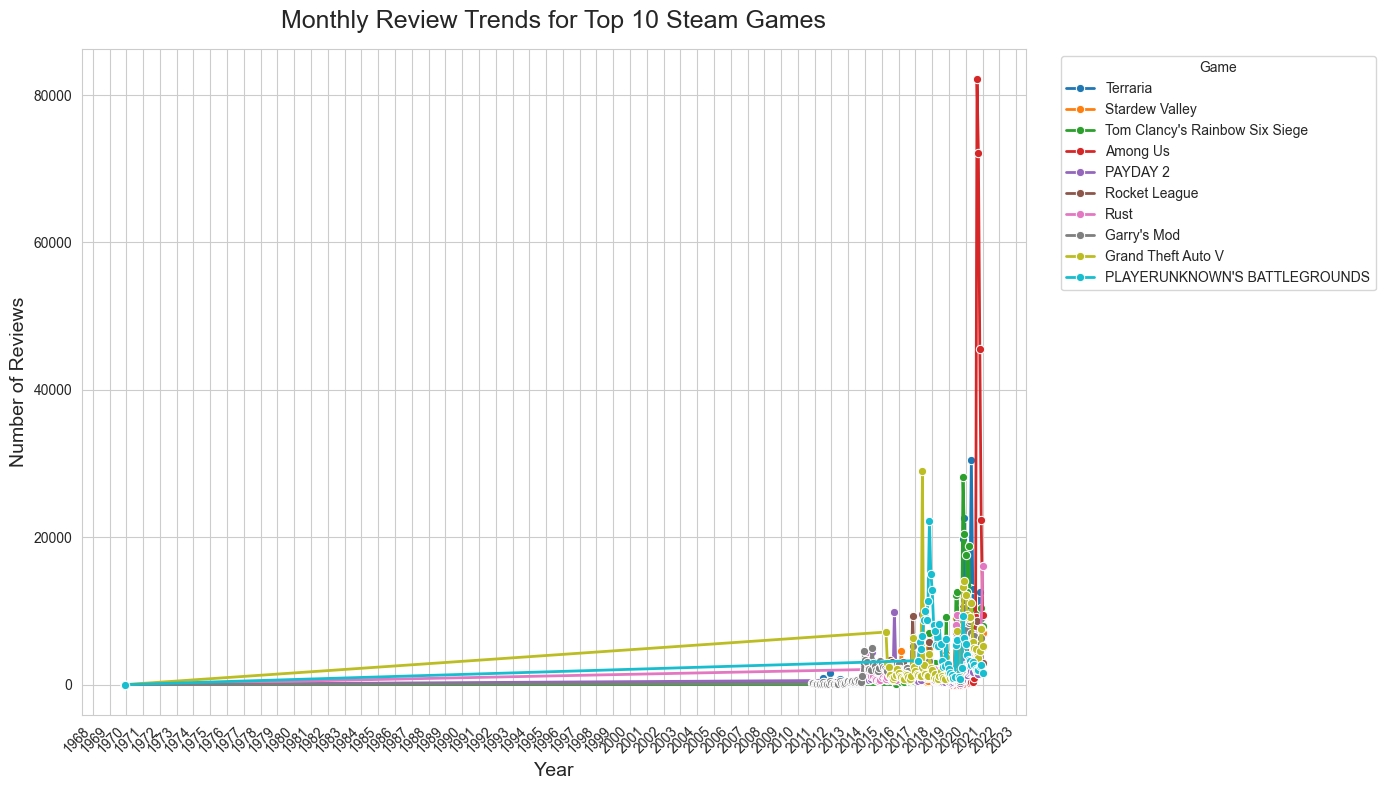

In [65]:
from pyspark.sql.functions import date_format, col
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# ——————————————————————————————————————————
# 1) Create a “YYYY-MM” bucket column
by_month = english_df.withColumn(
    "year_month",
    date_format(col("timestamp_created"), "yyyy-MM")
)

# 2) Count reviews per game × month
monthly = (
    by_month
    .groupBy("app_name", "year_month")
    .count()
)

# 3) Pick the Top 10 games by total review volume
top10 = (
    monthly
    .groupBy("app_name")
    .sum("count")
    .orderBy(col("sum(count)").desc())
    .limit(10)
    .select("app_name")
)

# 4) Restrict to just those Top 10
monthly_top = monthly.join(top10, on="app_name", how="inner")

# 5) Bring into Pandas and parse dates
mt_pd = monthly_top.toPandas()
mt_pd["year_month"] = pd.to_datetime(mt_pd["year_month"] + "-01")

# 6) Plot a multi‐line with yearly ticks
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.lineplot(
    data=mt_pd,
    x="year_month", y="count",
    hue="app_name",
    marker="o",
    linewidth=2
)

# format x‐axis: one tick per year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

# labels & legend
plt.title("Monthly Review Trends for Top 10 Steam Games", fontsize=18, pad=15)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.legend(title="Game", bbox_to_anchor=(1.03,1), loc="upper left")
plt.tight_layout()
plt.show()


- Early years (<2010): Almost zero activity, Steam review volume was negligible.

- 2011–2015: A slow uptick as Steam grew, with evergreen hits like Grand Theft Auto V (yellow line) showing modest, steady review counts (a few-thousand/month).

- 2016–2019: We see the first big seasonal spikes:

- Rust (pink) jumps in mid-2018 when it left Early Access.

- **Rocket League (brown)** has a big burst around its free-play weekends.

- Late 2019–2020 (**“Among Us”** exploded):

#### Among Us (red) goes from almost zero reviews to over 80 000 reviews in a single month (September 2020) – that’s the hallmark of a true breakout “viral” game.

The other top titles also show elevated “background” review counts around November–December 2020, likely tied to Holiday sales and free weekends.


### Recommendation rate & Review Volume by Player Playtime

/var/folders/tr/db4czd8s5p72t4kg1tb2b47c0000gn/T/ipykernel_57006/1872065468.py:83: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


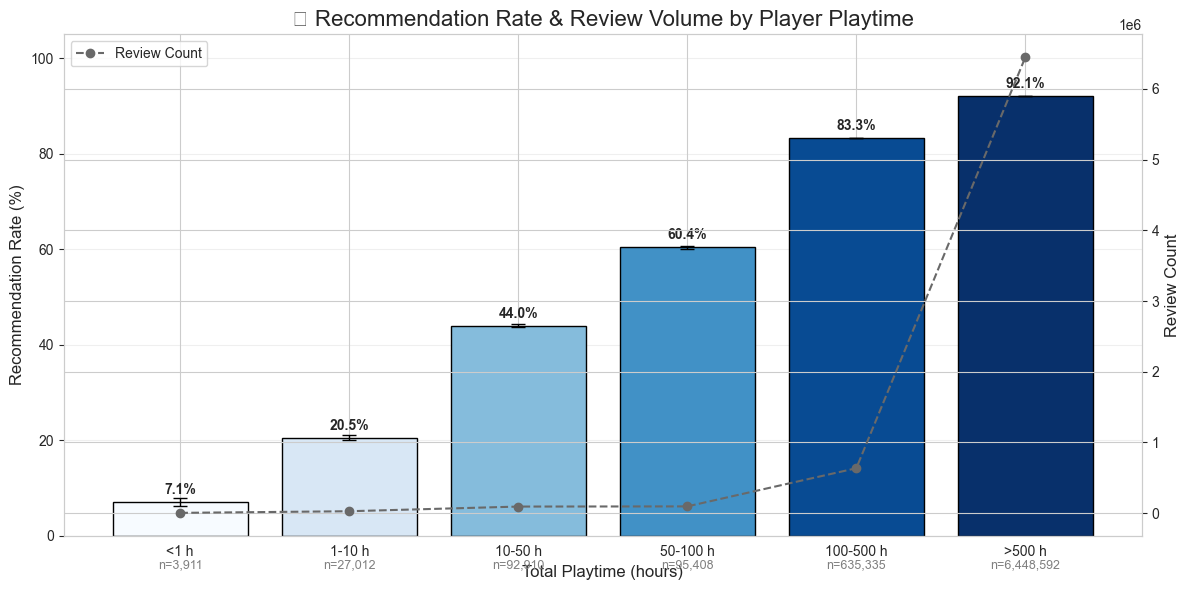

In [67]:
from pyspark.sql import functions as F
from pyspark.sql.functions import when, col, sum as Fsum, count as Fcount
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Define playtime bins and labels
bins = [0, 1, 10, 50, 100, 500]
labels = ['<1 h', '1-10 h', '10-50 h', '50-100 h', '100-500 h', '>500 h']

# 2) Assign each review to a playtime bin
pt_df = english_df.select('recommended', 'author_playtime_forever') \
    .withColumn('play_bin',
        when(col('author_playtime_forever') < bins[1], labels[0])
       .when((col('author_playtime_forever') >= bins[1]) & (col('author_playtime_forever') < bins[2]), labels[1])
       .when((col('author_playtime_forever') >= bins[2]) & (col('author_playtime_forever') < bins[3]), labels[2])
       .when((col('author_playtime_forever') >= bins[3]) & (col('author_playtime_forever') < bins[4]), labels[3])
       .when((col('author_playtime_forever') >= bins[4]) & (col('author_playtime_forever') < bins[5]), labels[4])
       .otherwise(labels[5])
    )

# 3) Aggregate per bin: total reviews and positive recommendations
stats_df = pt_df.groupBy('play_bin').agg(
    Fcount('*').alias('count'),
    Fsum(when(col('recommended') == True, 1).otherwise(0)).alias('num_rec')
).withColumn(
    'recommendation_rate',
    (col('num_rec') / col('count')) * 100
)

# 4) Add explicit bin order index for sorting
order_expr = when(col('play_bin') == labels[0], 0)
for idx, lab in enumerate(labels[1:], 1):
    order_expr = order_expr.when(col('play_bin') == lab, idx)
stats_df = stats_df.withColumn('bin_idx', order_expr).orderBy('bin_idx')

# 5) Convert to Pandas
rec_stats_pd = stats_df.select('play_bin', 'count', 'recommendation_rate').toPandas()
rec_stats_pd.rename(columns={'play_bin': 'bin_label'}, inplace=True)

# 6) Compute 95% CI for recommendation rate
p = rec_stats_pd['recommendation_rate'] / 100
n = rec_stats_pd['count']
rec_stats_pd['ci'] = 1.96 * np.sqrt(p * (1 - p) / n) * 100

# 7) Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for recommendation rates
norm = plt.Normalize(rec_stats_pd['recommendation_rate'].min(), rec_stats_pd['recommendation_rate'].max())
colors = plt.cm.Blues(norm(rec_stats_pd['recommendation_rate']))
bars = ax1.bar(rec_stats_pd['bin_label'], rec_stats_pd['recommendation_rate'],
               color=colors, edgecolor='black')

# Annotate percentage and sample size
for idx, row in rec_stats_pd.iterrows():
    ax1.text(idx, row['recommendation_rate'] + 1,
             f"{row['recommendation_rate']:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax1.text(idx, -5, f"n={int(row['count']):,}", ha='center', va='top', fontsize=9, color='gray')

# Error bars (CI)
ax1.errorbar(rec_stats_pd['bin_label'], rec_stats_pd['recommendation_rate'],
             yerr=rec_stats_pd['ci'], fmt='none', ecolor='black', capsize=5, linewidth=1)

# Primary axis settings
ax1.set_ylabel("Recommendation Rate (%)", fontsize=12)
ax1.set_ylim(0, 105)
ax1.set_xlabel("Total Playtime (hours)", fontsize=12)
ax1.set_title("🎯 Recommendation Rate & Review Volume by Player Playtime", fontsize=16)

# Secondary axis for review counts
ax2 = ax1.twinx()
ax2.plot(rec_stats_pd['bin_label'], rec_stats_pd['count'],
         marker='o', linestyle='--', color='dimgray', label='Review Count')
ax2.set_ylabel("Review Count", fontsize=12)

# Legend & grid
lines, labels_leg = ax2.get_legend_handles_labels()
ax1.legend(lines, labels_leg, loc='upper left')
ax1.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


For the **“<1 h” bar**, n = 3911 means we only have 3 911 reviews from people who’ve played under one hour.

For the **“1–10 h” bar**, n = 27012 reviews, and so on up to the 6 448 592 reviews from folks with > 500 h played.

### Recommendation rate rises with playtime

- Newcomers (< 1 hour of gameplay): only about 7.1 % recommend, but this is based on just n = 3,911 reviews.

- Light players (1–10 h): jump to 20.5 % (n = 27,012).

- Mid‐range (10–50 h): 44.0 % (n = 92 ,910).

- Regulars (50–100 h): 60.4 % (n = 95 ,408).

- Heavy players (100–500 h): 83.3 % (n = 635 ,335).

- Hardcore veterans (> 500 h): 92.1 % (n = 6 ,448 ,592).

**Volume is heavily skewed toward long‐time players**

The dashed gray line (right axis) shows there are millions of reviews from the > 500 h bucket, but only a few thousand from players who’ve tried < 1 h.

Those huge sample sizes make the confidence intervals for the last two bars almost invisible, whereas the CI for the < 1 h group is wide, reminding us that small-n bins are noisy.